In [1]:
import os 


In [4]:
num_videos = []
import numpy as np 
for i in os.listdir('data'):
   action = os.path.join("data/"+i)
   num_videos.append(action)

print(sum(num_videos))

#    if i == 'alive':
#     for video in os.listdir(action):
#         print(len(video))
#     break
      

  



TypeError: unsupported operand type(s) for +: 'int' and 'str'

In [5]:
import os
num_videos = []
for i in os.listdir('data'):
    path = os.path.join('data', i)
    if os.path.isdir(path):
        num_videos.append(len(os.listdir(path)))
print(sum(num_videos))


790


In [45]:
data_path = os.path.join('augmented_videos')
for i in os.listdir('data'):

    os.rmdir(os.path.join(data_path,i))


In [2]:
!pip install imgaug

  Using cached pillow-11.3.0-cp39-cp39-win_amd64.whl.metadata (9.2 kB)
  Using cached matplotlib-3.9.4-cp39-cp39-win_amd64.whl.metadata (11 kB)
  Using cached opencv_python-4.12.0.88-cp37-abi3-win_amd64.whl.metadata (19 kB)
  Using cached contourpy-1.3.0-cp39-cp39-win_amd64.whl.metadata (5.4 kB)
  Using cached cycler-0.12.1-py3-none-any.whl.metadata (3.8 kB)
  Using cached fonttools-4.60.1-cp39-cp39-win_amd64.whl.metadata (114 kB)
  Using cached kiwisolver-1.4.7-cp39-cp39-win_amd64.whl.metadata (6.4 kB)
  Using cached pyparsing-3.2.5-py3-none-any.whl.metadata (5.0 kB)
  Using cached importlib_resources-6.5.2-py3-none-any.whl.metadata (3.9 kB)
   ---------------------------------------- 0.0/948.0 kB ? eta -:--:--
   ---------------------------------------- 0.0/948.0 kB ? eta -:--:--
   ----------- ---------------------------- 262.1/948.0 kB ? eta -:--:--
   ----------- ---------------------------- 262.1/948.0 kB ? eta -:--:--
   --------------------- ---------------- 524.3/948.0 kB 508.

In [1]:
import numpy as np 
print(np.__version__)

1.22.4


In [2]:
import cv2
import numpy as np
import imgaug as ia
import imgaug.augmenters as iaa
import os

def augment_video(input_video_path, output_directory, num_augmentations_per_video=3):
    """
    Applies data augmentation to a video and saves the augmented versions.

    Args:
        input_video_path (str): Path to the input video file.
        output_directory (str): Directory where augmented videos will be saved.
        num_augmentations_per_video (int): Number of augmented versions to create for each video.
    """

    if not os.path.exists(output_directory):
        os.makedirs(output_directory)

    cap = cv2.VideoCapture(input_video_path)
    if not cap.isOpened():
        print(f"Error: Could not open video {input_video_path}")
        return

    # Get video properties
    fps = cap.get(cv2.CAP_PROP_FPS)
    width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    original_frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

    # Define augmentation sequence
    # This sequence will apply the same transformation to each frame for temporal consistency
    seq = iaa.Sequential([
        iaa.Fliplr(0.5), # horizontally flip 50% of all images
        iaa.Sometimes(0.5, # apply to 50% of all images
            iaa.GaussianBlur(sigma=(0, 0.5))
        ),
        iaa.LinearContrast((0.75, 1.5)), # improve or worsen the contrast
        iaa.AdditiveGaussianNoise(loc=0, scale=(0.0, 0.05*255), per_channel=0.5), # add gaussian noise
        iaa.Multiply((0.8, 1.2), per_channel=0.5), # change brightness
        iaa.Affine(
            scale={"x": (0.8, 1.2), "y": (0.8, 1.2)},
            translate_percent={"x": (-0.2, 0.2), "y": (-0.2, 0.2)},
            rotate=(-25, 25),
            shear=(-8, 8)
        )
    ], random_order=True) # apply augmenters in random order

    video_name = os.path.basename(input_video_path).split('.')[0]

    for i in range(num_augmentations_per_video):
        print(f"Augmenting video: {video_name}, Version: {i+1}")

        # Create a video writer for the augmented video
        output_video_path = os.path.join(output_directory, f"{video_name}_aug_{i+1}.mp4")
        # Use XVID for better compatibility or 'mp4v' for H.264
        fourcc = cv2.VideoWriter_fourcc(*'mp4v') # or 'XVID'
        out = cv2.VideoWriter(output_video_path, fourcc, fps, (width, height))

        cap.set(cv2.CAP_PROP_POS_FRAMES, 0) # Reset video capture to the beginning for each augmentation

        # Get a new random state for each augmentation to ensure different results
        # This is crucial for applying different augmentations across versions
        # We need to apply the SAME random transformation to ALL frames of a single augmented video
        # So we augment an empty list of images once to get a fixed augmenter for this specific video
        aug_det = seq.to_deterministic()

        current_frame_count = 0
        while True:
            ret, frame = cap.read()
            if not ret:
                break

            # Convert frame to imgaug format (RGB)
            frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

            # Apply the *same* deterministic augmentation to the current frame
            # We use aug_det here to ensure all frames in a video get the same transformation
            augmented_frame_rgb = aug_det.augment_image(frame_rgb)

            # Convert back to OpenCV format (BGR)
            augmented_frame_bgr = cv2.cvtColor(augmented_frame_rgb, cv2.COLOR_RGB2BGR)

            out.write(augmented_frame_bgr)
            current_frame_count += 1
            if current_frame_count % 100 == 0:
                print(f"  Processed {current_frame_count}/{original_frame_count} frames.")

        out.release()
        print(f"Saved augmented video: {output_video_path}")

    cap.release()

# --- Example Usage ---
# if __name__ == "__main__":
#     # Create a dummy video for demonstration
#     dummy_video_path = "dummy_video.mp4"
#     output_fps = 10
#     output_width = 320
#     output_height = 240
#     num_frames = 50

#     # Create a dummy video writer
#     fourcc = cv2.VideoWriter_fourcc(*'mp4v')
#     dummy_out = cv2.VideoWriter(dummy_video_path, fourcc, output_fps, (output_width, output_height))

#     for i in range(num_frames):
#         frame = np.zeros((output_height, output_width, 3), dtype=np.uint8)
#         # Draw some moving shapes to make the video interesting
#         cv2.circle(frame, ((i*5) % output_width, (i*3) % output_height), 20, (0, 0, 255), -1)
#         cv2.rectangle(frame, ((i*2) % output_width, (i*4) % output_height),
#                       ((i*2+50) % output_width, (i*4+50) % output_height), (0, 255, 0), -1)
#         cv2.putText(frame, f"Frame {i}", (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2)
#         dummy_out.write(frame)
#     dummy_out.release()
#     print(f"Created dummy video: {dummy_video_path}")
    
#     # Now, run the augmentation
#     input_video = "dummy_video.mp4" # Replace with your video file
#     output_dir = "augmented_videos"
#     augment_video(input_video, output_dir, num_augmentations_per_video=3)

#     print("\nAugmentation complete. Check the 'augmented_videos' directory.")

In [52]:
input_video = "data/alive/MVI_9703.MOV" # Replace with your video file
output_dir = "augmented_videos"
augment_video(input_video, output_dir, num_augmentations_per_video=5)

print("\nAugmentation complete. Check the 'augmented_videos' directory.")

Augmenting video: MVI_9703, Version: 1
Saved augmented video: augmented_videos\MVI_9703_aug_1.mp4
Augmenting video: MVI_9703, Version: 2
Saved augmented video: augmented_videos\MVI_9703_aug_2.mp4
Augmenting video: MVI_9703, Version: 3
Saved augmented video: augmented_videos\MVI_9703_aug_3.mp4
Augmenting video: MVI_9703, Version: 4
Saved augmented video: augmented_videos\MVI_9703_aug_4.mp4
Augmenting video: MVI_9703, Version: 5
Saved augmented video: augmented_videos\MVI_9703_aug_5.mp4

Augmentation complete. Check the 'augmented_videos' directory.


In [ ]:
# Process videos from all folders
DATA_PATH = os.path.join('data')
actions = os.listdir(DATA_PATH)
# Remove any non-directory items or hidden folders
actions = [action for action in actions if os.path.isdir(os.path.join(DATA_PATH, action)) and not action.startswith('.')]

# Dictionary to store sequences for each action
action_sequences = {}

# Number of frames to extract from each video
SEQUENCE_LENGTH = 30  # 30 frames = 1 second at 30fps

# Process each action folder
for action in actions:
    action_sequences[action] = []
    action_dir = os.path.join(DATA_PATH, action)
    
    # Get all video files in the action directory
    videos = [f for f in os.listdir(action_dir) if f.endswith('.MOV')]
    
    print(f"Processing videos for action: {action}")
    for video in videos:
        video_path = os.path.join(action_dir, video)
        # Process the video and get keypoints
        
        

Processing videos for action: alive
data\alive\MVI_9703.MOV
data\alive\MVI_9704.MOV
data\alive\MVI_9705.MOV
data\alive\MVI_9706.MOV
data\alive\MVI_9827.MOV
data\alive\MVI_9828.MOV
data\alive\MVI_9829.MOV
data\alive\MVI_9830.MOV
Processing videos for action: bad
data\bad\MVI_5161.MOV
data\bad\MVI_5162.MOV
data\bad\MVI_5163.MOV
data\bad\MVI_5241.MOV
data\bad\MVI_5242.MOV
data\bad\MVI_5243.MOV
data\bad\MVI_5319.MOV
data\bad\MVI_5320.MOV
data\bad\MVI_5321.MOV
data\bad\MVI_9271.MOV
data\bad\MVI_9272.MOV
data\bad\MVI_9273.MOV
data\bad\MVI_9352.MOV
data\bad\MVI_9353.MOV
data\bad\MVI_9354.MOV
data\bad\MVI_9433.MOV
data\bad\MVI_9434.MOV
data\bad\MVI_9435.MOV
data\bad\MVI_9513.MOV
data\bad\MVI_9514.MOV
data\bad\MVI_9516.MOV
Processing videos for action: Beautiful
data\Beautiful\MVI_9569.MOV
data\Beautiful\MVI_9570.MOV
data\Beautiful\MVI_9571.MOV
data\Beautiful\MVI_9572.MOV
data\Beautiful\MVI_9723.MOV
data\Beautiful\MVI_9724.MOV
data\Beautiful\MVI_9725.MOV
data\Beautiful\MVI_9726.MOV
Processing v

In [58]:
import cv2
import numpy as np
import imgaug as ia
import imgaug.augmenters as iaa
import os
import glob
import shutil

# --- Augmentation Sequence Definition ---
def get_augmentation_sequence():
    return iaa.Sequential([
        iaa.Fliplr(0.5),
        iaa.Sometimes(0.5, iaa.GaussianBlur(sigma=(0, 0.5))),
        iaa.LinearContrast((0.75, 1.5)),
        iaa.AdditiveGaussianNoise(loc=0, scale=(0.0, 0.05*255), per_channel=0.5),
        iaa.Multiply((0.8, 1.2), per_channel=0.5),
        iaa.Affine(
            scale={"x": (0.8, 1.2), "y": (0.8, 1.2)},
            translate_percent={"x": (-0.2, 0.2), "y": (-0.2, 0.2)},
            rotate=(-25, 25),
            shear=(-8, 8),
            order=[0, 1]
        )
    ], random_order=True)

def augment_single_video(input_video_path, output_directory, num_augmentations_to_generate):
    """
    Applies data augmentation to a single video and saves the augmented versions.
    Augmented videos are named as original_name_aug_X.mp4

    Args:
        input_video_path (str): Path to the input video file.
        output_directory (str): Directory where augmented videos will be saved.
        num_augmentations_to_generate (int): Number of augmented versions to create for this video.
    """

    if num_augmentations_to_generate <= 0:
        return

    cap = cv2.VideoCapture(input_video_path)
    if not cap.isOpened():
        print(f"Error: Could not open video {input_video_path}")
        return

    # Get video properties
    fps = cap.get(cv2.CAP_PROP_FPS)
    width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    original_frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

    if original_frame_count == 0:
        print(f"Warning: Video {input_video_path} has 0 frames. Skipping.")
        cap.release()
        return

    video_name_without_ext = os.path.basename(input_video_path).split('.')[0]

    for i in range(num_augmentations_to_generate):
        output_video_path = os.path.join(output_directory, f"{video_name_without_ext}_aug_{i+1}.mp4")
        os.makedirs(output_directory, exist_ok=True)

        fourcc = cv2.VideoWriter_fourcc(*'mp4v') # or 'XVID'
        out = cv2.VideoWriter(output_video_path, fourcc, fps, (width, height))

        if not out.isOpened():
            print(f"Error: Could not create video writer for {output_video_path}. Check codecs/permissions.")
            continue

        cap.set(cv2.CAP_PROP_POS_FRAMES, 0) # Reset video capture to the beginning for each augmentation

        aug_seq = get_augmentation_sequence()
        aug_det = aug_seq.to_deterministic()

        while True:
            ret, frame = cap.read()
            if not ret:
                break
            frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            augmented_frame_rgb = aug_det.augment_image(frame_rgb)
            augmented_frame_bgr = cv2.cvtColor(augmented_frame_rgb, cv2.COLOR_RGB2BGR)
            out.write(augmented_frame_bgr)

        out.release()

    cap.release()

def process_dataset_to_fixed_size(
    base_data_path,
    output_base_path,
    target_videos_per_class=40, # <<< --- YOUR FIXED REQUIREMENT --- >>>
    extensions=['.mov', '.mp4', '.avi', '.mkv']
):
    """
    Processes a video dataset, maintaining folder structure and aiming for a fixed number of videos per class.
    Each class will be augmented until it reaches target_videos_per_class.

    Args:
        base_data_path (str): The root directory containing class folders (e.g., 'data/').
        output_base_path (str): The root directory where augmented data will be saved.
        target_videos_per_class (int): The exact number of videos (originals + augmented) desired for each class.
        extensions (list): List of video file extensions to look for.
    """
    
    print(f"Starting dataset processing from: {base_data_path}")
    print(f"Output will be saved to: {output_base_path}")
    
    if not os.path.exists(output_base_path):
        os.makedirs(output_base_path)

    class_folders = [d for d in os.listdir(base_data_path) if os.path.isdir(os.path.join(base_data_path, d))]
    
    if not class_folders:
        print(f"No class folders found in {base_data_path}. Please check the path.")
        return

    print(f"Found {len(class_folders)} class folders: {class_folders}")

    # First pass: Gather video counts for all classes
    class_video_paths = {} # Stores list of video paths for each class
    class_video_counts = {} # Stores count of videos for each class

    for class_name in class_folders:
        class_path = os.path.join(base_data_path, class_name)
        videos_in_class = []
        for ext in extensions:
            videos_in_class.extend(glob.glob(os.path.join(class_path, f"*{ext}")))
            videos_in_class.extend(glob.glob(os.path.join(class_path, f"*{ext.upper()}")))
        
        class_video_paths[class_name] = videos_in_class
        class_video_counts[class_name] = len(videos_in_class)
    
    print("\nOriginal video counts per class:")
    for class_name, count in class_video_counts.items():
        print(f"  {class_name}: {count} videos")
    print(f"\nTargeting exactly {target_videos_per_class} total videos for each class.")


    # Second pass: Process and augment
    for class_name in class_folders:
        input_class_path = os.path.join(base_data_path, class_name)
        output_class_path = os.path.join(output_base_path, class_name)
        
        os.makedirs(output_class_path, exist_ok=True)

        videos_in_class = class_video_paths[class_name]
        current_original_video_count = class_video_counts[class_name]

        print(f"\nProcessing class '{class_name}': Original count = {current_original_video_count}")

        if current_original_video_count == 0:
            print(f"  Class '{class_name}' has no original videos. Cannot reach target of {target_videos_per_class}. Skipping.")
            continue
        
        if current_original_video_count > target_videos_per_class:
            print(f"  Warning: Class '{class_name}' has {current_original_video_count} original videos, which is MORE than the target {target_videos_per_class}. Only copying original videos (no augmentations).")
            # In this case, we just copy the originals, we won't remove any.
            # If you want to sample down, that's a different strategy.
            videos_to_process = videos_in_class 
            augmentations_to_generate_per_video_list = [0] * len(videos_to_process)
        else:
            videos_to_process = videos_in_class # All original videos will be used
            needed_augmented_count = target_videos_per_class - current_original_video_count
            
            # Distribute needed_augmented_count among the original videos
            augmentations_to_generate_per_video_list = np.array_split(
                np.arange(needed_augmented_count),
                current_original_video_count
            )
            augmentations_to_generate_per_video_list = [len(x) for x in augmentations_to_generate_per_video_list]

        print(f"  Each video will generate {augmentations_to_generate_per_video_list} augmented copies (total for class: {sum(augmentations_to_generate_per_video_list)})")
        
        for idx, video_path in enumerate(videos_to_process):
            original_video_name = os.path.basename(video_path)
            
            # Copy the original video
            try:
                shutil.copy2(video_path, os.path.join(output_class_path, original_video_name))
            except Exception as e:
                print(f"  Warning: Could not copy original video {original_video_name} to output. Error: {e}")

            # Augment the video based on calculated needs
            num_aug_for_this_video = augmentations_to_generate_per_video_list[idx]
            print(f"  Augmenting {original_video_name} with {num_aug_for_this_video} copies...")
            augment_single_video(
                input_video_path=video_path,
                output_directory=output_class_path,
                num_augmentations_to_generate=num_aug_for_this_video
            )
            
    print("\nFixed-size dataset augmentation complete!")
    print(f"Augmented videos and original videos are saved in: {output_base_path}")


if __name__ == "__main__":
 
    YOUR_BASE_INPUT_DATA_DIR = "data" 

    YOUR_OUTPUT_AUGMENTED_DATA_DIR = "augmented_videos"

    config_target_videos_per_class = 40 


    process_dataset_to_fixed_size(
        base_data_path=YOUR_BASE_INPUT_DATA_DIR,
        output_base_path=YOUR_OUTPUT_AUGMENTED_DATA_DIR,
        target_videos_per_class=config_target_videos_per_class
    )

    print("\nScript finished. Check the output directory for your augmented data.")
    print(f"Output path: {YOUR_OUTPUT_AUGMENTED_DATA_DIR}")

Starting dataset processing from: data
Output will be saved to: augmented_videos
Found 59 class folders: ['alive', 'bad', 'Beautiful', 'big large', 'Blind', 'cheap', 'clean', 'cold', 'cool', 'curved', 'dead', 'Deaf', 'deep', 'dirty', 'dry', 'expensive', 'famous', 'fast', 'female', 'flat', 'good', 'happy', 'hard', 'healthy', 'heavy', 'high', 'hot', 'light', 'long', 'loose', 'loud', 'low', 'male', 'Mean', 'narrow', 'new', 'Nice', 'old', 'poor', 'quiet', 'rich', 'sad', 'shallow', 'short', 'sick', 'slow', 'small little', 'soft', 'strong', 'tall', 'thick', 'thin', 'tight', 'Ugly', 'warm', 'weak', 'wet', 'wide', 'young']

Original video counts per class:
  alive: 16 videos
  bad: 42 videos
  Beautiful: 16 videos
  big large: 42 videos
  Blind: 16 videos
  cheap: 16 videos
  clean: 16 videos
  cold: 40 videos
  cool: 42 videos
  curved: 16 videos
  dead: 16 videos
  Deaf: 16 videos
  deep: 16 videos
  dirty: 16 videos
  dry: 42 videos
  expensive: 16 videos
  famous: 16 videos
  fast: 42 vide

Loading both un-normalized and normalized data...
Data loaded successfully.


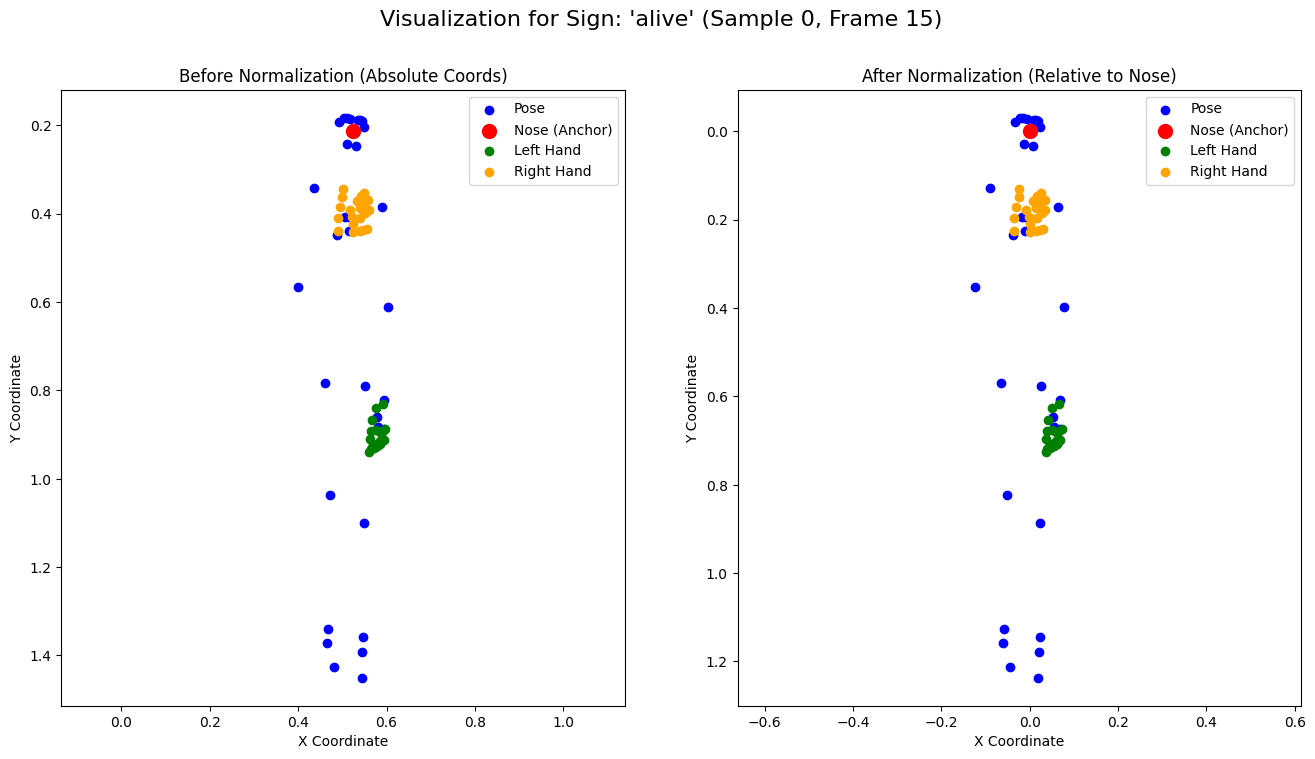


--- Data Comparison ---
Sign: 'alive'

BEFORE Normalization - Nose (x, y): (0.5248, 0.2136)
AFTER Normalization  - Nose (x, y): (0.0000, 0.0000) <-- Should be 0.0

BEFORE Normalization - R.Hand Tip (x, y): (0.5496, 0.3533)
AFTER Normalization  - R.Hand Tip (x, y): (0.0248, 0.1398)

--- Interpretation ---
The 'Before' plot shows the keypoints at their original positions in the video frame.
The 'After' plot shows all keypoints centered around the nose at (0, 0).
This proves the normalization worked, making the data 'position-independent'.


In [1]:

import os
import numpy as np
import json
import matplotlib.pyplot as plt


# Step 3: Define Paths
# --------------------
# Path to your NON-NORMALIZED (original augmented) data
UNNORMALIZED_PATH = 'processed_2_data' 

# Path to your NEW NORMALIZED data
NORMALIZED_PATH = 'processed_3_data_normalized'

# Step 4: Load Data
# -----------------
print("Loading both un-normalized and normalized data...")
try:
    # Load un-normalized data
    X_unnormalized = np.load(os.path.join(UNNORMALIZED_PATH, 'X.npy'))
    
    # Load normalized data
    X_normalized = np.load(os.path.join(NORMALIZED_PATH, 'X.npy'))
    
    # Load labels (they are the same for both)
    y_labels = np.load(os.path.join(NORMALIZED_PATH, 'y.npy'))
    with open(os.path.join(NORMALIZED_PATH, 'action_labels.json'), 'r') as f:
        action_to_label = json.load(f)
    
    # Create a reverse mapping to get action names
    label_to_action = {v: k for k, v in action_to_label.items()}
    
except FileNotFoundError as e:
    print(f"ERROR: Could not find .npy files. Check your paths.")
    print(e)
    raise

print("Data loaded successfully.")

# Step 5: Define Plotting Function
# --------------------------------
def plot_keypoints(frame_data, ax, title):
    """
    Plots the pose, left hand, and right hand keypoints
    from a single 258-length frame array.
    """
    # Reshape frame to easily access keypoints
    pose = frame_data[0:132].reshape(33, 4)
    lh = frame_data[132:195].reshape(21, 3)
    rh = frame_data[195:258].reshape(21, 3)
    
    # Plot Pose (using x, y)
    ax.scatter(pose[:, 0], pose[:, 1], c='blue', label='Pose')
    # Plot Nose (keypoint 0) as a big red dot
    ax.scatter(pose[0, 0], pose[0, 1], c='red', s=100, label='Nose (Anchor)')
    
    # Plot Left Hand (using x, y)
    ax.scatter(lh[:, 0], lh[:, 1], c='green', label='Left Hand')
    
    # Plot Right Hand (using x, y)
    ax.scatter(rh[:, 0], rh[:, 1], c='orange', label='Right Hand')
    
    ax.set_title(title)
    ax.set_xlabel('X Coordinate')
    ax.set_ylabel('Y Coordinate')
    ax.legend()
    # Invert Y-axis to match image coordinates (top-left is 0,0)
    ax.invert_yaxis()
    ax.axis('equal') # Ensure aspect ratio is preserved

# Step 6: Choose a Sample and Plot
# --------------------------------
# You can change these indices to see different signs/frames
SAMPLE_INDEX = 0  # Which sign to look at
FRAME_INDEX = 15  # Which frame (0-29) of the sign to plot

# Get the action name
action_name = label_to_action.get(y_labels[SAMPLE_INDEX], "Unknown")

# Get the specific frame from both datasets
frame_unnormalized = X_unnormalized[SAMPLE_INDEX][FRAME_INDEX]
frame_normalized = X_normalized[SAMPLE_INDEX][FRAME_INDEX]

# Create the plots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))
fig.suptitle(f"Visualization for Sign: '{action_name}' (Sample {SAMPLE_INDEX}, Frame {FRAME_INDEX})", fontsize=16)

# Plot 1: Before Normalization
plot_keypoints(frame_unnormalized, ax1, "Before Normalization (Absolute Coords)")

# Plot 2: After Normalization
plot_keypoints(frame_normalized, ax2, "After Normalization (Relative to Nose)")

plt.show()

# Step 7: Print some data for comparison
# --------------------------------------
print("\n--- Data Comparison ---")
print(f"Sign: '{action_name}'\n")

# Get Nose (keypoint 0), x and y
nose_x_before = frame_unnormalized[0]
nose_y_before = frame_unnormalized[1]
print(f"BEFORE Normalization - Nose (x, y): ({nose_x_before:.4f}, {nose_y_before:.4f})")

nose_x_after = frame_normalized[0]
nose_y_after = frame_normalized[1]
print(f"AFTER Normalization  - Nose (x, y): ({nose_x_after:.4f}, {nose_y_after:.4f}) <-- Should be 0.0\n")

# Get Right Hand Index Finger Tip (keypoint 8 in rh)
# rh starts at index 195. Keypoint 8 is (8*3) = 24 indices in.
# So, index = 195 + 24 = 219 (for x) and 220 (for y)
rh_tip_x_before = frame_unnormalized[219]
rh_tip_y_before = frame_unnormalized[220]
print(f"BEFORE Normalization - R.Hand Tip (x, y): ({rh_tip_x_before:.4f}, {rh_tip_y_before:.4f})")

rh_tip_x_after = frame_normalized[219]
rh_tip_y_after = frame_normalized[220]
print(f"AFTER Normalization  - R.Hand Tip (x, y): ({rh_tip_x_after:.4f}, {rh_tip_y_after:.4f})")

print("\n--- Interpretation ---")
print("The 'Before' plot shows the keypoints at their original positions in the video frame.")
print("The 'After' plot shows all keypoints centered around the nose at (0, 0).")
print("This proves the normalization worked, making the data 'position-independent'.")

In [1]:
import tensorflow as tf 

In [2]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    for gpu in gpus:
        tf.config.experimental.set_memory_growth(gpu, True)
    print(f"GPU found and available: {gpus}")
else:
    print("No GPU found. Training will be on CPU.")

No GPU found. Training will be on CPU.


In [1]:
import tensorflow as tf 

In [2]:
print(tf.__version__)

2.12.0


In [3]:
tf.keras.models.load_model("sign_language_GRU_model_76.78%")